# Handling Simple Predicate Push-down

As the HL-LHC gets underway, one thing that we will have to deal with is datasets that are so large they do not fit in memory. One solution is to use predicate-push-down to select only the data we need. For example, if we are reconstructing $W \rightarrow e^+ e^-$ we may as well only look at electrons with $p_T > 20$ GeV. Thus, before trying to do anything in memory, we can just ask only for electrons with $p_T > 20$ GeV. The 20 GeV cut is applied in a layer below us in this case.

In IRIS-HEP, the `ServiceX` project works this way. It makes simple selections to try to reduce the amount of data that has to be shipped to the client for analysis.

How will this interact with automatic differentiation? Lets assume the subsystem that is executing the predicate knows nothing about differentiation - it is dumb and just performs the cuts is must.

There are two steps:

1. Calculating the loss means applying the cut to the full dataset.
1. Calculating the gradient means really only looking at the data where the differential around the `erf` function is non-zero.

Note that this is distinct from two systems that both understand auto-diff trying to work together to have a full blown differentiable pipe-line that crosses the systems. That isn't to say that one might want to implement that as a wrapper for something like predicate push-down! But this page is about solving a much simpler program.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax_helpers import erf, predict, loss, training_truth, training_data
import matplotlib.pyplot as plt

_ = plt.ion()

## Derivative of the `erf` Function

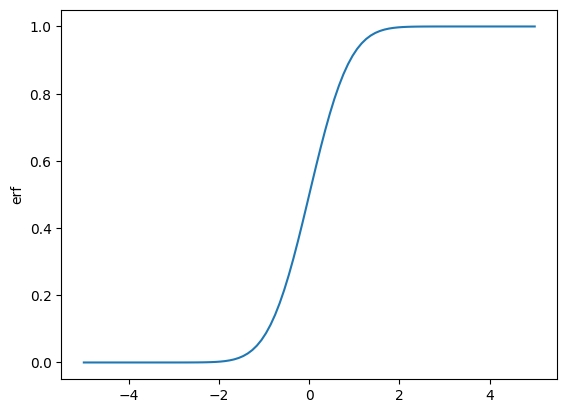

In [2]:
x_values = np.linspace(-5, 5, 100)

def my_erf(x_value: float):
    v = erf(jnp.asarray([x_value]), 0.0)
    return v[0]

erf_values = np.array([my_erf(x) for x in x_values])

plt.plot(x_values, erf_values)
plt.ylabel('erf')
plt.show()

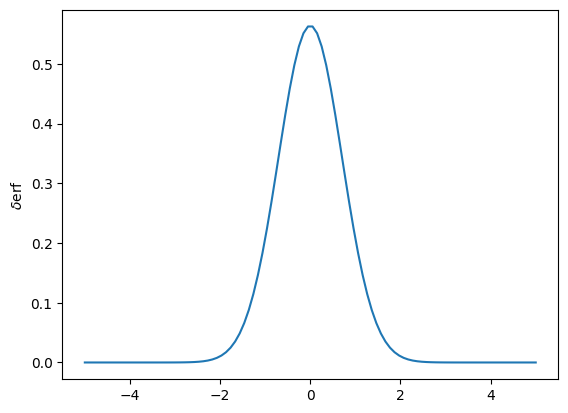

In [3]:
d_my_erf = jax.grad(my_erf)
d_erf_values = np.array([d_my_erf(x) for x in x_values])

plt.plot(x_values, d_erf_values)
plt.ylabel(r'$\delta$erf')
plt.show()

This says that when calculating the derivative, only the values that are $\pm 4$ around the central value of the cut are "interesting" for the gradient calculation.

* Interesting aspect of this - often these cuts happen on the falling side of a exponential distribution. So going below a cut value can require significantly more data to be pumped through the system, even if it is a small window.

To test this, lets calculate our loss gradient on a full signal and background, and then only on the part of that is within $\pm 4$ of the cut value we are looking at.

In [4]:
d_loss = jax.grad(loss)
full_loss = d_loss(0.0, training_data, training_truth)

In [5]:
def masked_loss_deriv(window_half: float):
    'After masking the data around the cut calculate the loss for the masked data'
    erf_window_mask = (training_data > -window_half) & (training_data < window_half)
    masked_training_data = training_data[erf_window_mask]
    masked_training_truth = training_truth[erf_window_mask]
    return d_loss(0.0, masked_training_data, masked_training_truth)

In [6]:
window_values = np.linspace(1.0, 4.0, 40)
masked_loss = np.array([masked_loss_deriv(v) for v in window_values])

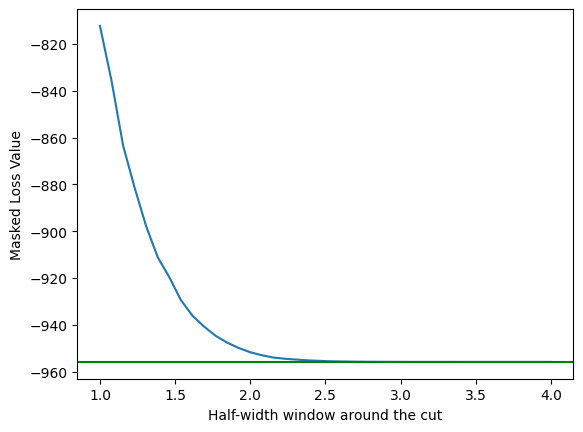

In [7]:
plt.plot(window_values, masked_loss)
plt.axhline(full_loss, color='green')
plt.ylabel('Masked Loss Value')
plt.xlabel('Half-width window around the cut')
plt.show()

For the current implementation of the error function (which we know is too wide), a cut window of 2.5 is actually all that is needed to get the derivative of the loss function values to match with a full dataset. This 2.5 is also what would be needed when calculating the `erf` for the loss function itself (e.g. you could request data for `> (cut_value - 2.5)`, and then have everything you needed.

## What data does training need?

In the last chapter we wrote out the cuts during training. We can read this in and along with the 2.5 from above, we can start to better understand what we can do when working with a system like `ServiceX`.

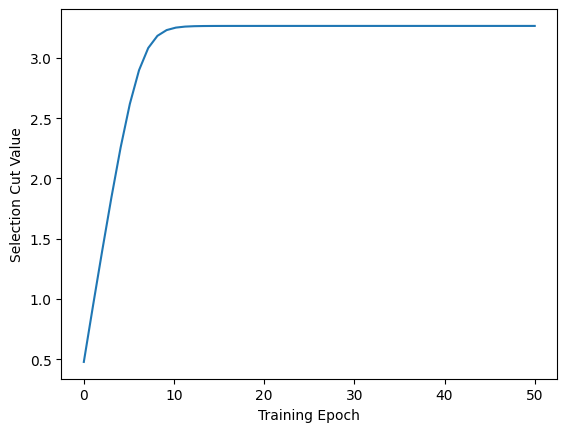

In [8]:
cut_data = np.loadtxt('_cut.log')
plt.plot(np.linspace(0, len(cut_data)), cut_data)
plt.xlabel('Training Epoch')
plt.ylabel('Selection Cut Value')
plt.show()

This training started at 0.5, and rapidly moved up to its final result. From the point of view of saving data, with this scheme and the 2.5 buffer we needed from above, we would have needed the whole data.

There might be a way to be smarter about this - for example, always start the cuts from a large value - or perhaps the value that will - but with lots of cuts things will get a bit tougher to seed.

The right conclusion here seems to be that you load all the data from ServiceX and then use that training data to do the learning. Then during inference, you use the the actual cut in push-down and minimize the data pulled from SX. This aligns with the fact that the training data will likely be small compared to the full dataset that is pulled from the full HL-LHC dataset.